In [1]:
import warnings
warnings.filterwarnings("ignore")
import h5py
import numpy as np
import pandas as pd
import os,sys
import glob
from scipy import stats
import random
import gempy as gp
from gempy.bayesian.fields import probability, information_entropy, fuzziness, total_model_entropy

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['seaborn-talk'])

sys.path.append('../models/20210319_MC_no_middle_filling/')

print(f"Run mit GemPy version {gp.__version__}")

Run mit GemPy version 2.2.9


# Rejection algorithm based on random walk
We created a tiny ensemble of 100 different SHEMAT-Suite and will use a rejection algorithm based on the Metropolis acceptance probability to get a posterior ensemble of models.  
The Metropolis acceptance probability is defined as:  

$$ \alpha(x_{t-1},z) = \begin{cases} min\big(\frac{p(z)}{p(x_{t-1})},1\big), & \text{if } p(x_{t-1}) > 0\\
1, & \text{if } p(x_{t-1}) = 0 \end{cases} $$  

A different approach would be to assess the missfit (as RMS error) of each realisation.  

$$ \alpha(x_{t-1},z) = \begin{cases} exp\big(-\frac{S(z) - S(x_{t-1}) }{u_T}\big), & \text{if } S(z) > S(x_{t-1})\\
1, & \text{otherwise }  \end{cases} $$  

We will use the second approach for now...also because we wrote it in the abstract.  
As discretization error, we take a value from Elison(2015), $u_{T-discr} = 0.7$ K  

Using Gauss error propagation, we assess a potential error for the realisations.  

$$ u_T = \sqrt{\big(\frac{\partial T}{\partial x_1}u_1 \big)^2 + ... + \big(\frac{\partial T}{\partial x_n}u_n \big)^2} $$

Literature sources for log-errors:
_The lower part of the disturbed log profile (below the cross-over point) was rotated to match these corrected tempera-tures. In the upper part of the profile, the same correction as for method A was applied. The quality of this correction method strongly depends on the correct calculation of the lowermost profile temperatures. According to Förster (2001), most of the corrected tem-peratures have errors of ± 3 to 5 K._ https://doi.org/10.1186/s40517-020-00181-w  


 _The effective accuracy of commercial temperature logs is ±0.5ºC (Blackwell and Spafford, 1987)._  http://www.sprensky.com/publishd/temper2.html  
 
 _More normal accuracies are +- 0.25 °C over 0-200 °C_ Keith Geothermal Energy lecture  
 
 For errors as a function of e.g. logging speed, measurement response time etc, look https://doi.org/10.1016/j.petrol.2020.107727

In [2]:
# get delx and dely of the model, so cell sizes
delx = 28000 / 100
dely = 14000 / 50

In [3]:
# import DTM
dtm = np.load('../models/20210319_MC_no_middle_filling/Graben_base_model/Graben_base_model_topography.npy')

In [4]:
# load base model
model_path = '../models/2021-06-04_POC_base_model/'

geo_model = gp.load_model('POC_PCT_model', 
                          path=model_path, recompile=False)

Active grids: ['regular']
Active grids: ['regular' 'topography']


In [5]:
# import gravity data and borehole locations
g_data = pd.read_csv('../models/20210319_MC_no_middle_filling/2021-06-16_grav_of_POC_base_model.csv')
bhole = np.array([[31, 14],
                 [78, 22],
                 [53, 34],
                 [49, 44]])

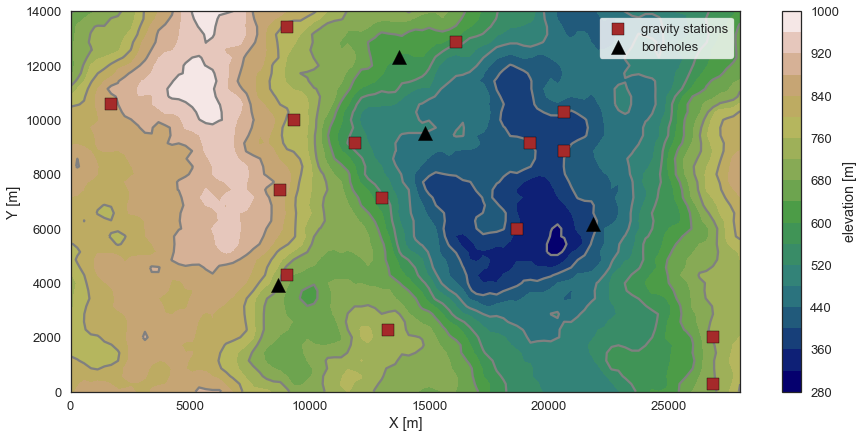

In [6]:
fig = plt.figure(figsize=[15,7])
cs = plt.contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth')
plt.contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
plt.scatter(g_data['X'], g_data['Y'], marker='s', s=150, c='brown', edgecolor='k', 
            label='gravity stations', zorder=2)
plt.scatter(bhole[:,0]*delx, bhole[:,1]*dely, marker='^', s=200, c='k', label='boreholes',
           zorder=3)
plt.colorbar(cs, label='elevation [m]')
plt.legend(frameon=True)
plt.xlabel('X [m]')
plt.ylabel('Y [m]');
#fig.savefig('../imgs/Model_topography_and_grav_stations.png', dpi=300, bbox_inches='tight')

## Load the Lithology Blocks

In [7]:
full_ens = np.load('../../../data_var/lith_block_samples_all_1000real.npy')

In [8]:
prior_prob = probability(full_ens)
prior_entr = information_entropy(prior_prob)

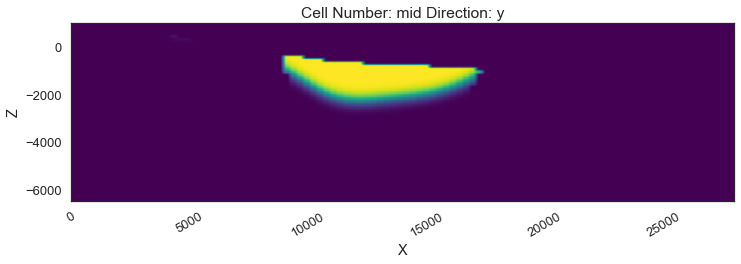

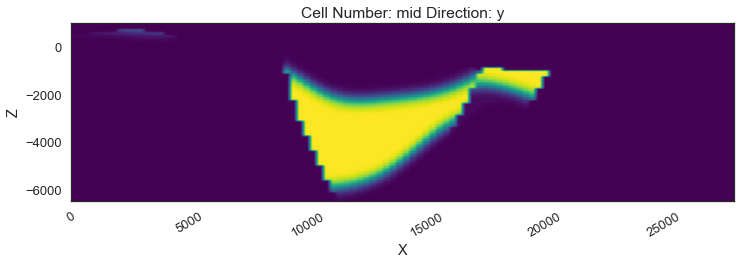

In [9]:
layer = 5
# upper filling
gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_prob[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None})
# lower filling
gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_prob[layer+1],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None});

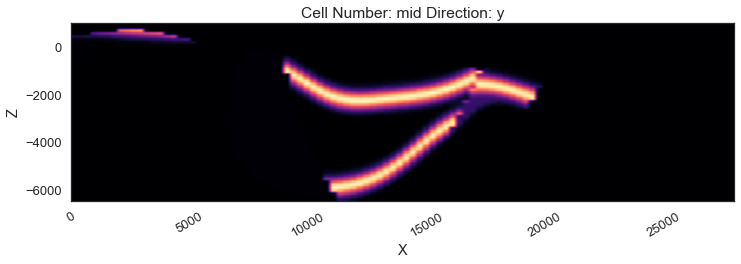

In [10]:
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_entr,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )


# Gravity rejection
In a first stage, we take a look at the gravity signal of each realization. The gravity signal is "recorded" at each of the squares you see in the plot above. Comparing the recorded gravity signals of each realization with the ones of the base model (which we regard as the "true" observations), we can differentiate between fitting and non-fitting ensemble members.

In [11]:
g_simu = pd.read_csv('../models/20210319_MC_no_middle_filling/MC_grav_simulations_run01and02_1000_reals_rseed0_250+50mstd.csv',
                    sep=';')

In [12]:
add_noise = True
if add_noise==True:
    np.random.seed(27)
    noise = np.random.normal(0, 1., size=15)
    g_data_noise = g_data.copy()
    g_data_noise['grav'] = g_data_noise['grav'] + noise
    print(np.mean(noise))

0.32409402260706643


In [13]:
#calculate stdeviation and mean of the prior ensemble
g_simu_stdev = g_simu.std(axis=1)
g_simu_mean = g_simu.mean(axis=1)

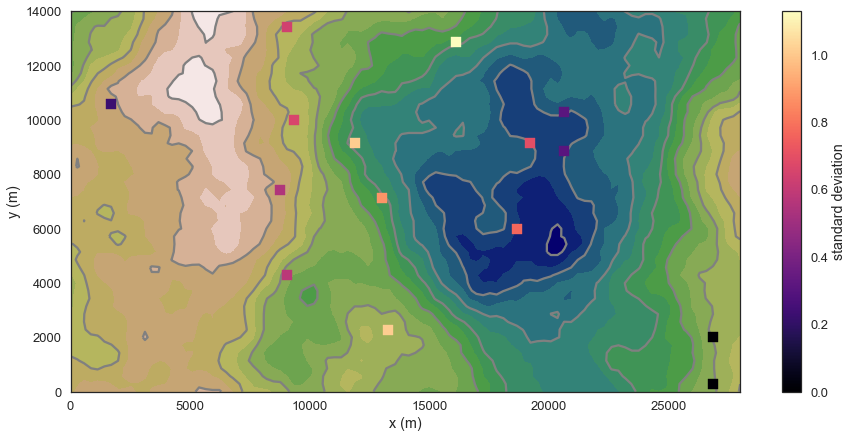

In [14]:
fig = plt.figure(figsize=[15,7])
cs = plt.contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth')
plt.contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
cs = plt.scatter(g_data['X'], g_data['Y'], c=g_simu_stdev, marker='s', 
                 s=100, zorder=2, cmap='magma')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar(cs, label='standard deviation');

In [15]:
g_simu_stdev

0     1.137437e-13
1     5.770345e-01
2     6.586363e-01
3     6.387890e-01
4     2.261284e-01
5     5.508696e-01
6     3.086279e-01
7     7.680910e-01
8     1.128918e+00
9     1.012097e+00
10    1.012580e+00
11    3.090857e-01
12    6.964663e-01
13    8.775207e-01
14    1.137437e-13
dtype: float64

we see that station 0 and 14 are not sensitive to changing the PCT depth, so they are not really helping in the rejection, but are influencing the RMSE. With focusing on the sensitive locations, we are likely to increase the performance of the rejection algorithm.

In [16]:
# drop the first and last entry which do not show variation
simu_drop = g_simu.drop(labels=[0,14], axis=0)
simu_drop_std = simu_drop.std(axis=1)
#station_drop = g_coordinates.drop(labels=[0,14], axis=0)
g_data_drop = g_data.drop(labels=[0,14], axis=0)
g_data_noise_drop = g_data_noise.drop(labels=[0,14], axis=0)

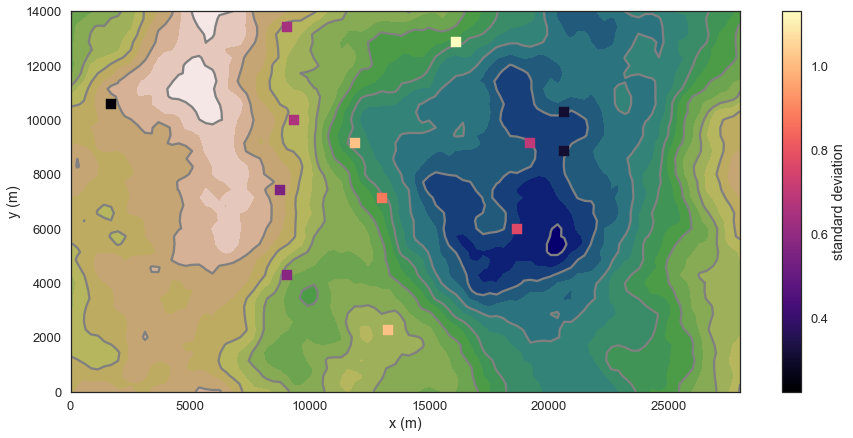

In [17]:
fig = plt.figure(figsize=[15,7])
cs = plt.contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth')
plt.contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
cs = plt.scatter(g_data_drop['X'], g_data_drop['Y'], c=simu_drop_std, marker='s', s=100,
                cmap='magma', zorder=2)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar(cs, label='standard deviation');

In [86]:
random.seed(27)
# uncertainty
u_g = np.mean(noise)

# calculate diffs
n = simu_drop.shape[0]
g_sim_diffssq = g_simu.sub(g_data_drop['grav'], axis=0)**2

rmse = np.sqrt((g_sim_diffssq.sum(axis=0)/n))


Ref = rmse[0]
accept = []
P = []
k = 0
for i in range(1,len(rmse)):
    if rmse[i] < Ref:
        Ref = rmse[i]
        accept.append(i)
        
    elif random.random() < np.exp(-(rmse[i] - Ref)/(u_g)):
        P.append(np.exp(-(rmse[i] - Ref)/(u_g)))
        Ref = rmse[i]
        accept.append(i)
        k +=1
print(f"{len(accept)} realizations were accepted.")
print(f"Accepted realizations: {accept}")

595 realizations were accepted.
Accepted realizations: [1, 2, 3, 4, 8, 9, 10, 11, 13, 16, 18, 20, 22, 23, 24, 25, 27, 28, 29, 30, 32, 36, 41, 42, 43, 45, 47, 48, 53, 54, 56, 58, 59, 60, 64, 65, 66, 67, 68, 69, 70, 71, 72, 75, 76, 79, 80, 81, 82, 83, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 107, 109, 110, 112, 113, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127, 128, 130, 134, 136, 137, 138, 140, 141, 142, 143, 144, 145, 148, 149, 151, 152, 153, 156, 157, 158, 159, 160, 161, 163, 164, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 180, 182, 183, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 198, 200, 203, 204, 210, 211, 214, 216, 218, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 239, 242, 244, 246, 248, 253, 254, 255, 256, 259, 262, 264, 266, 268, 275, 276, 277, 278, 279, 280, 282, 284, 285, 286, 289, 290, 291, 293, 294, 296, 297, 298, 300, 301, 302, 304, 306, 310, 312, 316, 317, 318, 322, 324, 325, 327, 331, 332, 335, 336, 337, 

## With noisy data
What if we add noise to our data?

In [83]:
random.seed(27)

# uncertainty
u_g = np.mean(noise)

# calculate diffs
n = g_simu.shape[0]
g_sim_diffssq = g_simu.sub(g_data_noise['grav'], axis=0)**2

rmse = np.sqrt((g_sim_diffssq.sum(axis=0)/n))


Ref = rmse[0]
accept = []
P = []
k = 0
for i in range(1,len(rmse)):
    if rmse[i] < Ref:
        Ref = rmse[i]
        accept.append(i)
        
    elif random.random() < np.exp(-(rmse[i] - Ref)/(u_g)):
        P.append(np.exp(-(rmse[i] - Ref)/(u_g)))
        Ref = rmse[i]
        accept.append(i)
        k +=1
print(f"{len(accept)} realizations were accepted.")
print(f"Accepted realizations: {accept}")

745 realizations were accepted.
Accepted realizations: [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 60, 62, 64, 65, 66, 68, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119, 121, 122, 123, 124, 126, 127, 128, 130, 131, 132, 133, 134, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 170, 171, 174, 175, 177, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 200, 203, 204, 205, 206, 207, 210, 211, 212, 213, 214, 216, 217, 218, 220, 221, 222, 225, 226, 227, 228, 230, 231, 232, 233, 234, 236, 237, 238, 242, 243, 244, 246, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260, 262, 264, 266, 267, 268, 270, 27

We see that here, more realizations get accepted, in this case around 16 % more.

In [88]:
accepted_reals = full_ens[accept, :]

In [89]:
accepted_reals.shape

(595, 300000)

In [90]:
np.save('../../../data_var/lith_blocks_samples_run01and02.npy', full_ens)
np.save('../../../data_var/lith_blocks_accepted_23042021.npy', accepted_reals)
np.save('../../../data_var/accepted_realizations_23042021.npy', accept)

## Temperature rejection

In [91]:
f = h5py.File('../models/20210219_MC_ensemble/PCT_base_model_final.h5','r')

In [92]:
z,y,x = f['uindex'].shape

In [93]:
def fahrenheit_to_celsius(temp_fahrenheit, difference=False):
    if not difference:
        return (temp_fahrenheit - 32) * 5 / 9
    else:
        return temp_fahrenheit * 5 / 9
    
    
def extTui(datafile, dimension=3, direction='x'):
    f = h5py.File(datafile,'r')
    z, y, x = f['temp'].shape
    if dimension==3:
        temp = f['temp'][:,:,:]
        uindex = f['uindex'][:,:,:]
    elif dimension==2:
        if direction=='x':
            temp = f['temp'][:,:,x//2]
            uindex = f['uindex'][:,:,x//2]
        elif direction=='y':
            temp = f['temp'][:,y//2,:]
            uindex = f['uindex'][:,y//2,:]
        elif direction=='z':
            temp = f['temp'][z//2,:,:]
            uindex = f['uindex'][z//2,:,:]
    return temp,uindex
    

In [94]:
# define uT
T_error = 0.25 # temperature error tool accuracy
s_error = fahrenheit_to_celsius(1.25, difference=True) # sensor response time of 2 sec and 1 year after drilling
l_error = fahrenheit_to_celsius(1.25, difference=True) # logging speed of 20/ft after 1 year
d_error = 1.0 # estimated temperature error by discretization
#u_T = np.sqrt(T_error[0]**2 + T_error[1]**2 + T_error[2]**2 + T_error[3]**2 + d_error**2)
#u_T = np.sum(T_error**2)/4
u_T = np.sqrt(T_error**2 + s_error**2 + l_error**2 + d_error**2)
print(u_T)

1.4237296698599444


In [95]:
# load Simulation outputs. Those outputs get written by SHEMAT-Suite if runmode = 1
outp_path = '../models/20210319_MC_no_middle_filling/SHEMAT_MC/'
accepted = np.loadtxt('../models/20210319_MC_no_middle_filling/accepted_realizations_01042021').astype(int)
diffs = np.loadtxt(outp_path+'PCT_MC_1dat_cor_final.dat',skiprows=3,usecols=(8,),dtype=float)
for i in accepted[1:]:
    n = np.loadtxt(outp_path+f'PCT_MC_{i}dat_cor_final.dat',skiprows=3,usecols=(8,),dtype=float)
    diffs=np.vstack([diffs,n])

In [96]:
# calculate RMSE of each realisation.
n = diffs.shape[1] # as we have 4 data points for temperature

diffs_sq = diffs**2
ssr = diffs_sq.sum(axis=1)
rmse = np.sqrt((diffs_sq.sum(axis=1)/n))

In [97]:
# this is a matrix with all vectors. First 96 columns are differences of the wells, then the column is the SSR, 
# final column is RMSE
tot_diffs = np.column_stack((diffs,ssr,rmse))
print(tot_diffs.shape)
# add index to the realizations
ind = np.array(range(tot_diffs.shape[0]))
tot_diffs = np.column_stack((tot_diffs,accepted))

(626, 130)


## Rejection sampling
we now start with a random sample and go randomly through the pool, accepting and rejecting realizations.
The algorithm starts with one refrence sample `Ref`. Then, iteratively, samples (= realizations) get accepted, rejected based on their RMSE values. That is why we use the 6th column of `tot_diffs`. Alternatively, one could also just use the `rmse` array.

In [108]:
# Chronological implemntation - start von 1 bis N 
# Can be used here, if samples generated are already in a random order and not correlated.
# That is usually the case with GemPy exports to SHEMAT-Suite.
random.seed(42)
col = 129
Ref = tot_diffs[0,col]
accept = []
P = []
k=0
for i in range(1,tot_diffs.shape[0]):
    if tot_diffs[i,col] < Ref:
        Ref = tot_diffs[i,col]
        accept.append(i)
        
    elif random.random() < np.exp(-(tot_diffs[i,col] - Ref)/(u_T)):
        P.append(np.exp(-(tot_diffs[i,col] - Ref)/(u_T)))
        Ref = tot_diffs[i,col]
        accept.append(i)
        k += 1
print(len(accept))
print(accept)

507
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 53, 54, 55, 57, 58, 59, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 106, 108, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 125, 127, 128, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 164, 166, 167, 168, 169, 170, 171, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 215, 217, 218, 219, 220, 221, 224, 226, 227, 228, 229, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 

In [48]:
np.savetxt('../models/20210319_MC_no_middle_filling/accepted_after_temp_rejection', accept)

## Rejection sampling
we now start with a random sample and go randomly through the pool, accepting and rejecting realizations.
The algorithm starts with one refrence sample `Ref`. Then, iteratively, samples (= realizations) get accepted, rejected based on their RMSE values. That is why we use the 6th column of `tot_diffs`. Alternatively, one could also just use the `rmse` array.

In [109]:
# have a look at sensitive data points
st = np.std(diffs, axis=0)
st.shape

(128,)

(array([34., 27., 15.,  7., 11.,  5.,  1.,  1., 17., 10.]),
 array([0.0125289 , 0.19392582, 0.37532274, 0.55671966, 0.73811658,
        0.9195135 , 1.10091042, 1.28230734, 1.46370426, 1.64510118,
        1.8264981 ]),
 <BarContainer object of 10 artists>)

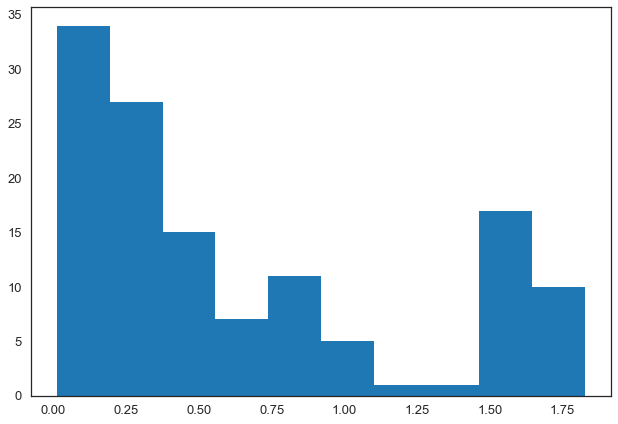

In [110]:
plt.hist(st)

We see, that there are many points not sensitive

In [111]:
indices = np.where(st < 0.5)

In [112]:
diffs_red = np.delete(diffs, obj=indices, axis=1)

Now let's see how the removal of relatively robust datapoints helps:

In [113]:
# calculate RMSE of each realisation.
n = diffs_red.shape[1] # as we have 4 data points for temperature

diffs_sq = diffs_red**2
ssr = diffs_sq.sum(axis=1)
rmse = np.sqrt((diffs_sq.sum(axis=1)/n))

In [114]:
# this is a matrix with all vectors. First 96 columns are differences of the wells, then the column is the SSR, 
# final column is RMSE
tot_diffs = np.column_stack((diffs_red,ssr,rmse))
print(tot_diffs.shape)
# add index to the realizations
ind = np.array(range(tot_diffs.shape[0]))
tot_diffs = np.column_stack((tot_diffs,accepted))

(626, 55)


In [115]:
# Chronological implemntation - start von 1 bis N 
# Can be used here, if samples generated are already in a random order and not correlated.
# That is usually the case with GemPy exports to SHEMAT-Suite.
random.seed(42)
col = 54
Ref = tot_diffs[0,col]
accept = []
P = []
k=0
for i in range(1,tot_diffs.shape[0]):
    if tot_diffs[i,col] < Ref:
        Ref = tot_diffs[i,col]
        accept.append(i)
        
    elif random.random() < np.exp(-(tot_diffs[i,col] - Ref)/(u_T)):
        P.append(np.exp(-(tot_diffs[i,col] - Ref)/(u_T)))
        Ref = tot_diffs[i,col]
        accept.append(i)
        k += 1
print(len(accept))
print(accept)

351
[1, 2, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 28, 29, 30, 33, 34, 35, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 84, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 106, 108, 117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131, 135, 136, 137, 138, 139, 142, 145, 146, 152, 153, 154, 155, 156, 157, 161, 169, 171, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 210, 211, 218, 219, 220, 221, 223, 224, 226, 227, 228, 229, 230, 232, 233, 234, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 265, 266, 267, 268, 269, 270, 271, 272, 274, 275, 276, 279, 280, 281, 282, 283, 288, 289, 290, 293, 297, 298, 299, 300, 302, 303, 320, 322, 327, 328, 329, 330, 331, 332, 333, 334, 335, 337, 339, 340, 341, 342, 344, 345, 346, 357, 359, 360, 361, 362, 365, 366,

In [56]:
np.savetxt('../models/20210319_MC_no_middle_filling/accepted_after_temp_rejection_reduced_datapoints', accept)

And we see, temperature data is not sensitive to changes in the PCT-depth.  

But what if we also treat the thermal conductivity as an uncertain parameter?

*Then the rejection is way more rigorous.*

In [79]:
fids = glob.glob('/home/bl2/ownCloud/SHEMAT_GeoMol/20210219_MC_outputs/*.h5')

In [80]:
outpath = '/home/bl2/ownCloud/SHEMAT_GeoMol/20210219_MC_outputs/'
poTemp = []
poUi = []
dicfil = {}
for fn in fids:
    for i in accept:
        if fn == outpath+"PCT_MC_{}var_TCt_final.h5".format(i):
            dT,dui = extTui(fn, dimension=2, direction='y')
            poTemp.append(dT)
            poUi.append(dui)            
            dicfil[fn.split('/')[-1]] = dui
            

In [81]:
poTempa = np.asarray(poTemp)
poUia = np.asarray(poUi)
accepta = np.asarray(accept)
print(poUia.shape,poTempa.shape,accepta.shape)
np.savetxt('accepted_realisations',accepta,fmt='%i',delimiter=' ',newline='\n')
#np.savetxt('posterior_Temps',poTempa,fmt='%.5f',delimiter=' ',newline='\n',header=" posterior 61 realizations for Temperature")
#np.savetxt('posterior_Uindex',poUia,fmt='%i',delimiter=' ',newline='\n')

(23, 60, 100) (23, 60, 100) (23,)


In [82]:
# calculate mean temperature field and mean posterior uindex
mTemp = np.mean(poTempa,axis=0)
mUi = np.mean(poUia,axis=0)
# import y and z for visualising
plfn = h5py.File('../models/20210219_MC_ensemble/PCT_base_model_final.h5','r')
x = plfn['x'][0,0,:]
y = plfn['y'][0,:,0]
z = plfn['z'][:,0,0]
refT = plfn['temp'][:,25,:]

In [83]:
poUi[0].shape

(60, 100)

Text(0, 0.5, 'depth[m]')

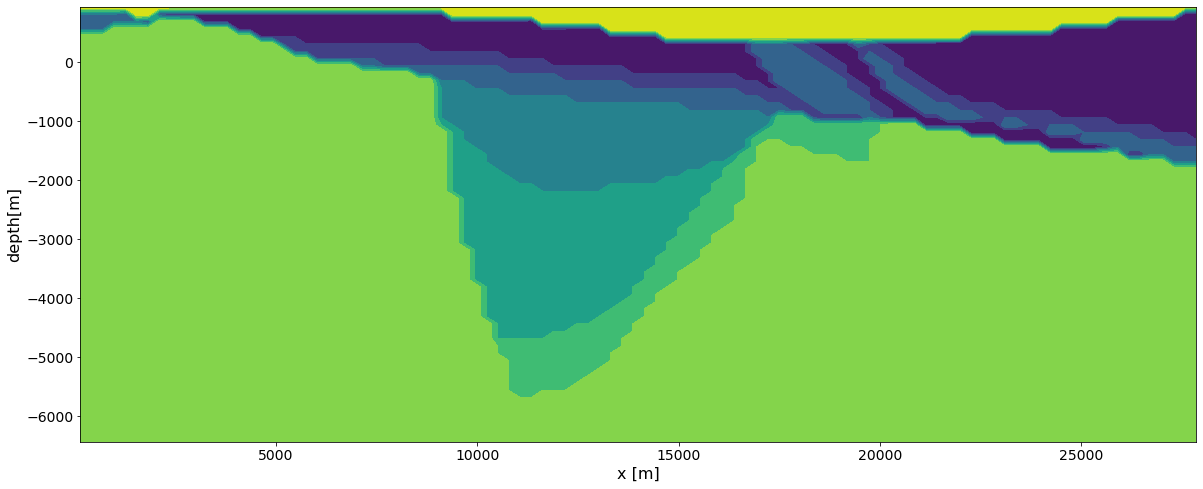

In [84]:
fig = plt.figure(figsize=(20,8))
cs = plt.contourf(x,z-6500.,mUi,cmap='viridis')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)

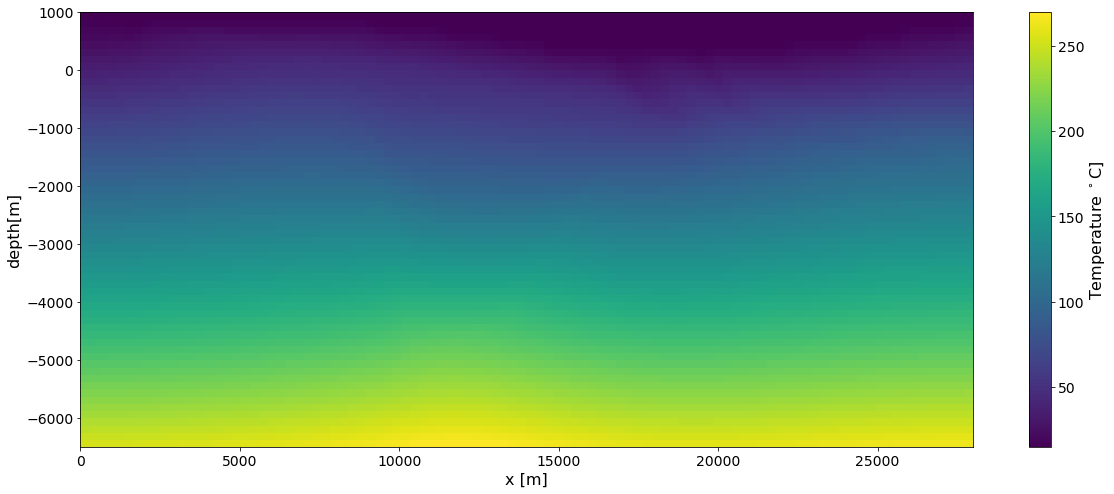

In [85]:
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,mTemp,cmap='viridis', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)

In [1]:
#plot ssr of mean posterior and reference model
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,(refT-mTemp)**2,cmap='RdBu', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)

NameError: name 'plt' is not defined